# Beginner friendly training and prediction with CNNs

Convolutional Neural Networks (CNNs) are a popular tool for developing automated machine learning classifiers on images or image-like samples. By converting audio into a two-dimensional frequency vs. time representation such as a spectrogram, we can generate image-like samples that can be used to train CNNs. This tutorial demonstrates the basic use of OpenSoundscape's `preprocessors` and `cnn` modules for training CNNs and making predictions using CNNs.

Under the hood, OpenSoundscape uses Pytorch for machine learning tasks. By using OpenSoundscape's CNN classes such as `PytorchModel` in combination with preprocessor classes such as `CnnPreprocessor`, you can train and predict with PyTorch's powerful CNN architectures in just a few lines of code. 

First, let's import some utilities.

In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learning model
from opensoundscape.preprocess.preprocessors import SpecPreprocessor

# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

Set manual seeds for pytorch and python. These ensure the training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [2]:
torch.manual_seed(0)
random.seed(0)

## Prepare audio data

### Download labeled audio files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's Raven sound analysis software.

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [3]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      5      0 --:--:--  0:00:01 --:--:--     8
100 9499k  100 9499k    0     0  2006k      0  0:00:04  0:00:04 --:--:-- 2928k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

### Generate one-hot encoded labels 

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

In [4]:
#load Specky output: a table of labeled audio files
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
specky_table.head()

,filename,woodcock,sound_type
0,d4c40b6066b489518f8da83af1ee4984.wav,present,song
1,e84a4b60a4f2d049d73162ee99a7ead8.wav,absent,na
2,79678c979ebb880d5ed6d56f26ba69ff.wav,present,song
3,49890077267b569e142440fa39b3041c.wav,present,song
4,0c453a87185d8c7ce05c5c5ac5d525dc.wav,present,song


This table must provide an accurate path to the files of interest. For this self-contained tutorial, we can use relative paths (starting with a dot and referring to files in the same folder), but you may want to use absolute paths for your training.

In [5]:
#update the paths to the audio files
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]
specky_table.head()

,filename,woodcock,sound_type
0,./woodcock_labeled_data/d4c40b6066b489518f8da8...,present,song
1,./woodcock_labeled_data/e84a4b60a4f2d049d73162...,absent,na
2,./woodcock_labeled_data/79678c979ebb880d5ed6d5...,present,song
3,./woodcock_labeled_data/49890077267b569e142440...,present,song
4,./woodcock_labeled_data/0c453a87185d8c7ce05c5c...,present,song


We then use the `categorical_to_one_hot` function from `opensoundscape.annotations` to crate "one hot" labels - that is, a column for every class, with 1 for present or 0 for absent in each sample's row. In this case, our classes are simply `'negative'` for files without a woodcock and `'positive'` for files with a woodcock. 

We'll need to put the paths to audio files as the index of the DataFrame.

Note that these classes are mutually exclusive, so we have a "single-target" problem, as opposed to a "multi-target" problem where multiple classes can simultaneously be present. 

In [6]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(specky_table[['woodcock']].values)
labels = pd.DataFrame(index=specky_table['filename'],data=one_hot_labels,columns=classes)
labels.head()

,absent,present
filename,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


If we want to, we can always convert one_hot labels back to categorical labels:

In [7]:
from opensoundscape.annotations import one_hot_to_categorical
categorical_labels = one_hot_to_categorical(one_hot_labels,classes)
categorical_labels[:3]

[['present'], ['absent'], ['present']]

### Split into training and validation sets
We use a utility from `sklearn` to randomly divide the labeled samples into two sets. The first set, `train_df`, will be used to train the CNN, while the second set, `valid_df`, will be used to test how well the model can predict the classes of samples that it was not trained with.

During the training process, the CNN will go through all of the samples once every "epoch" for several (sometimes hundreds of) epochs. Each epoch usually consists of a "learning" step and a "validation" step. In the learning step, the CNN iterates through all of the training samples while the computer program is modifying the weights of the convolutional neural network. In the validation step, the program performs prediction on all of the validation samples and prints out metrics to assess how well the classifier generalizes to unseen data.

In [8]:
from sklearn.model_selection import train_test_split
train_df,validation_df = train_test_split(labels,test_size=0.2,random_state=1)

## Create and train a model
Now, we create a convolutional neural network model object, train it on the `train_dataset` with validation from `validation_dataset`

### Set up a two-class, single-target model
This demonstrates using a two class, single-target model. 

* The two classes in this case are "positive" and "negative" 
* The model is "single target", meaning that each sample belongs to exactly one class, "positive" or "negative" 

We usually use two-class, single-target models to predict the presence or absence of a single species. We often refer to this as a "binary" model, but be careful not to confuse this for thresholded "binary" output predictions (1 or 0).

The model object should be initialized with a list of class names that matches the class names in the training dataset. Here we'll use the resnet18 architecture, a popular and powerful architecture that makes a good starting point. For more details on other CNN architectures, see the "Advanced CNN Training" tutorial.

In [9]:
# Create model object
classes = train_df.columns
model = CNN('resnet18',classes=classes,sample_duration=2.0,single_target=True)

### Inspect training images
Before creating a machine learning algorithm, we strongly recommend making sure the images coming out of the preprocessor look like you expect them to. Here we generate images for a few samples.

In [10]:
from opensoundscape.preprocess.utils import show_tensor #helper function to visualize processed samples

Now, load a handful of random samples, printing the labels and image for each:

labels: tensor([1, 0])


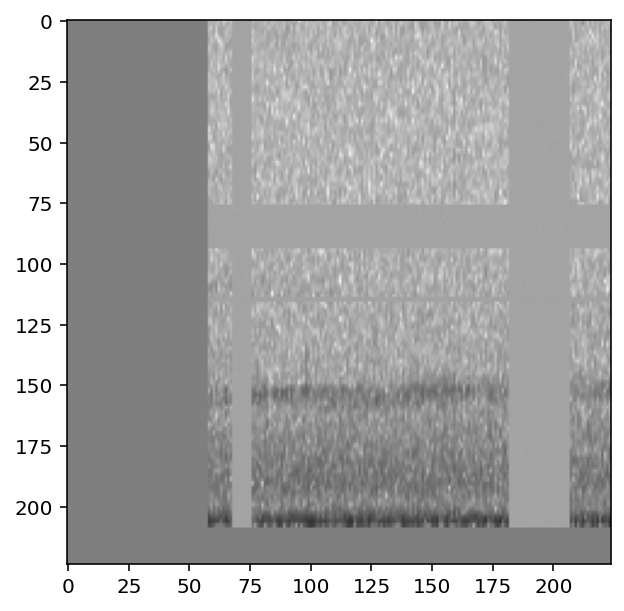

labels: tensor([1, 0])


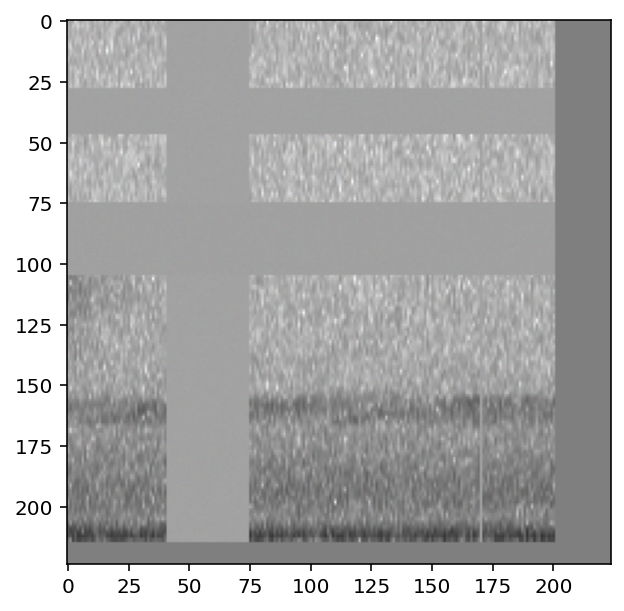

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([0, 1])


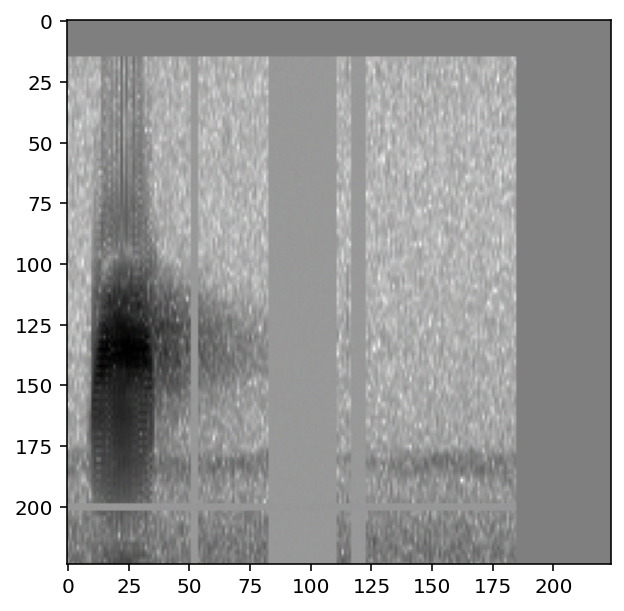

In [11]:
#pick some random samples and make a dataset from the model's preprocessor
#the dataset will generate samples using the combination of (1) a list of samples and (2) the preprocessor
sample_of_3 = train_df.sample(n=3)
sample_dataset = model.preprocessor.make_dataset(sample_of_3)

for sample in sample_dataset:
    print(f"labels: {sample['y']}")
    #use invert=True and transform_from_zero_centered=True to get a normal-looking spectrogram
    show_tensor(sample['X'],invert=True,transform_from_zero_centered=True)

The preprocessor allows you to turn all augmentation off or on as desired. Inspect the unaugmented images as well:

labels: tensor([1, 0])


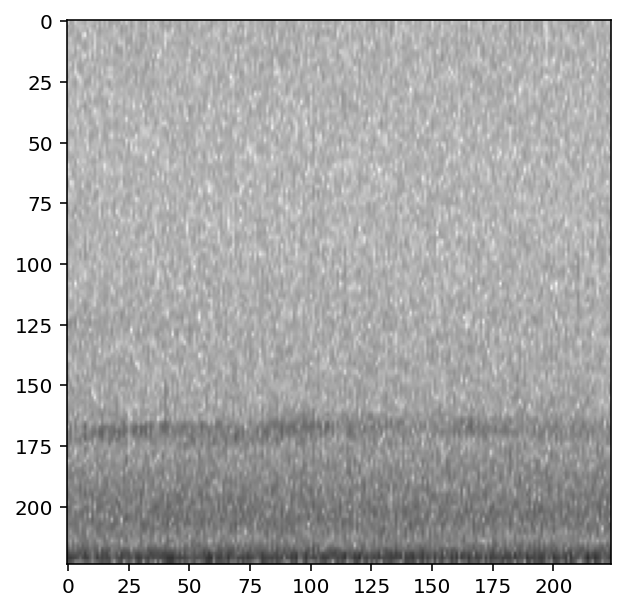

labels: tensor([1, 0])


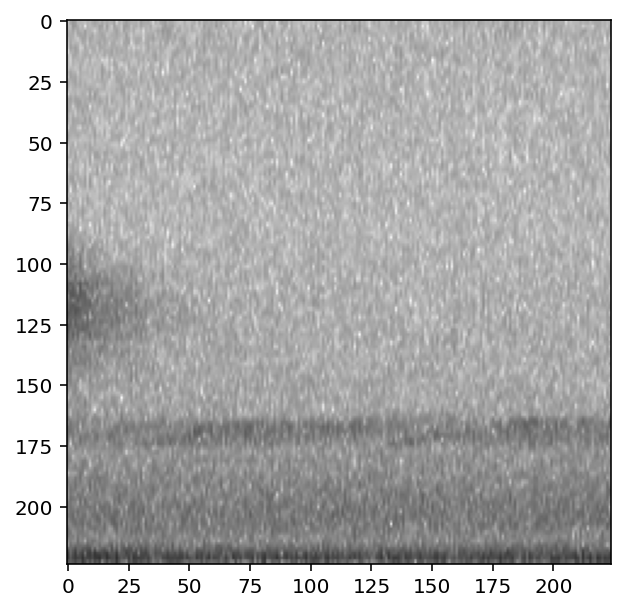

labels: tensor([0, 1])


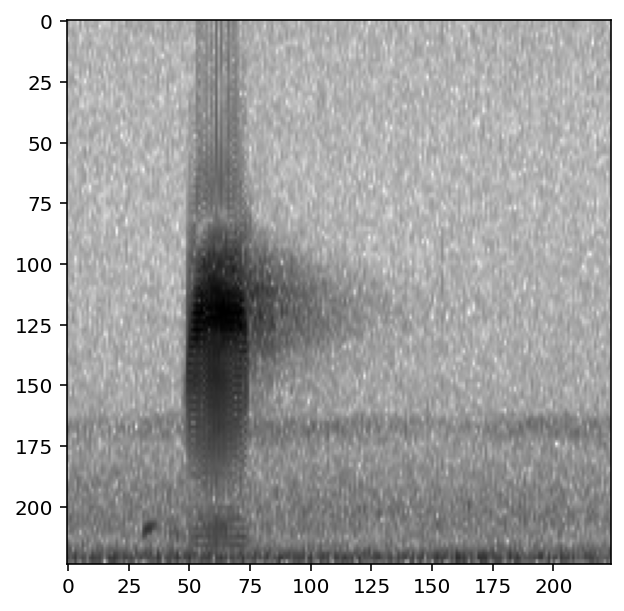

In [12]:
sample_dataset.augmentation_on=False
for sample in sample_dataset:
    print(f"labels: {sample['y']}")
    show_tensor(sample['X'],invert=True,transform_from_zero_centered=True)

### Train the model

Depending on the speed of your computer, training the CNN may take a few minutes.

We'll only train for 5 epochs on this small dataset as a demonstration, but you'll probably need to train for tens (or hundreds) of epochs on hundreds (or thousands) of training files to create a useful model. 

Batch size refers to the number of samples that are simultaneously processed by the model. In practice, using larger batch sizes (64+) improves stability and generalizability of training, particularly for architectures (such as ResNet) that contain a 'batch norm' layer. Here we use a small batch size to keep the computational reqirements for this tutorial low. 

In [13]:
model.train(
    train_df=train_df,
    validation_df=validation_df,
    save_path='./binary_train/', #where to save the trained model
    epochs=5,
    batch_size=8,
    save_interval=5, #save model every 5 epochs (the best model is always saved in addition)
    num_workers=0, #specify 4 if you have 4 CPU processes, eg; 0 means only the root process
)


Training Epoch 0
Epoch: 0 [batch 0/3 (0.00%)] 
	DistLoss: 0.778


ValueError: too many values to unpack (expected 2)

### Plot the loss history
We can plot the loss from each epoch to check that our loss is declining

In [ ]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

### Printing and Logging outputs
We can log the outputs of the training process to a file, and/or print them. We can independently modify how much content is logged/printed with the model's attributes `model.verbose` and `model.logging_level`. Content increases from level 0 (nothing) to 1 (standard), 2, 3, etc. For instance, let's train for an epoch with lots of logged content but no printed output: 

In [ ]:
model.logging_level = 3 #request lots of logged content
model.log_file = './binary_train/training_log.txt' #specify a file to log output to
model.verbose = 0 #don't print anything to the screen during training
model.train(
    train_df=train_df,
    validation_df=validation_df,
    save_path='./binary_train/', #where to save the trained model
    epochs=1,
    batch_size=8,
    save_interval=5, #save model every 5 epochs (the best model is always saved in addition)
    num_workers=0, #specify 4 if you have 4 CPU processes, eg; 0 means only the root process
)

## Prediction
We haven't actually trained a useful model in 5 epochs, but we can use the trained model to demonstrate how prediction works and show several of the settings useful for prediction.

We will run prediction on two one-minute clips of field data recorded by an AudioMoth acoustic recorded. The two files are located in `woodcock_labeled_data/field_data`

### Predict on the field data

To run prediction, also known as "inference", wich a CNN, we simply call model's `predict` method and pass it a list of file paths (or a dataframe with file paths in the index). 

The predict function will internally split audio files into the appropriate length clips for prediction and generate prediction scores for each clip. 

- By default, there is no overlap between these clips, but we can specify a fraction of overlap with consecutive clips with the `overlap_fraction` argument (eg, 0.5 for 50% overlap). 

- Additionally, if we want to predict on audio files that are already trimmed to the same duration as the training files, we can specify `split_files_into_clips=False`. 

Calling `.predict()` will return three things:

- scores dataframe: numeric predictions from the model for each sample and class (by default these are raw outputs from the model)

- predictions dataframe: 0/1 predictions from the model for each sample and class (only generated if `binary_predictions` argument is supplied)

- unsafe_samples: list of any samples that failed to load properly

Let's predict on the two field recordings:

In [ ]:
from glob import glob
field_recordings = glob('./woodcock_labeled_data/field_data/*')
field_recordings

In [ ]:
prediction_scores_df, prediction_binary_df, unsafe_samples = model.predict(field_recordings)

The predict function generated a dataframe with rows for each 2-second segment of each 1-minute audio clip. Let's look at the first few rows:

In [ ]:
prediction_scores_df.head()

Binary 0/1 predictions were not generated because the `binary_predictions` argument was not supplied

The `prediction_binary_df` dataframe is `None` - this is because we haven't specified an option for the `binary_preds` argument of predict. We can choose between `'single_target'` prediction (always predict the highest scoring class and no others) or `'multi_target'` (predict 1 for all classes exceeding a threshold).

In [ ]:
prediction_binary_df

If all of the samples were processed without errors, the unsafe_samples list will be empty

In [ ]:
unsafe_samples

### Create presence/absence (0/1) predictions

Supplying the `binary_preds` argument returns a dataframe in which the scores are transformed from continuous numbers to either 0 or 1. 

**Note**: Binary predictions always have some error rates, sometimes large ones. It is not generally advisable to use these binary predictions as scientific observations without a thorough understanding of the model's false-positive and false-negative rates.

If you wish to output binary predictions, three options are available:

* `None`: default. do not create or return binary predictions
* `'single_target'`: predict that the highest-scoring class = 1, all others = 0
* `'multi_target'`: provide a `threshold`. Scores above threshold = 1, others = 0

For instance, using the option `'single_target'` chooses whichever of `'negative'` or `'positive'` is higher.

In [ ]:
scores,preds,labels = model.predict(field_recordings,binary_preds='single_target')
preds.head()

The `'multi_target'` option allows you to select a threshold. If a score meets that threshold, the binary prediction is 1; otherwise, it is 0. 

Each score will have a function applied to it that takes the score from the real numbers, (-inf, inf), to the range [0, 1] (specifically the logistic sigmoid, or [expit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html) function). Whether the score meets this threshold will be based off of the sigmoid, not the raw score.

In [ ]:
score_df, pred_df, label_df = model.predict(
    validation_df,
    binary_preds='multi_target',
    threshold=0.99,
)
pred_df.head()

Note that in some of the above predictions, both the negative and positive classes are predicted to be present. This is because the `'multi_target'` option assumes that the classes are not mutually exclusive. For a presence/absence model like the one above, the `'single_target'` option is more appropriate.

### Change the activation layer
We can modify the final activation layer to change the scores returned by the `predict()` function. Note that this does not impact the results of the binary predictions (described above), which are always calculated using a sigmoid transformation (for multi-target models) or softmax function (for single-target models).

Options include:

* `None`: default. Just the raw outputs of the network, which are in (-inf, inf)
* `'softmax'`: scores across all classes will sum to 1 for each sample
* `'softmax_and_logit'`: softmax the scores across all classes so they sum to 1, then apply the "logit" transformation to these scores, taking them from [0,1] back to (-inf,inf)
* `'sigmoid'`: transforms each score individually to [0, 1] without requiring they sum to 1

In this case, since we are choosing between two mutually exclusive classes, we want to use the `'softmax'` activation.

Let's generate binary 0/1 predictions on the validation set. Since these samples are the same length as the training files, we'll specify `split_files_into_clips=False` (we just want one prediction per file, we don't want to divide each file into shorter clips).

In [ ]:
valid_scores, valid_preds, unsafe_samples = model.predict(
    validation_df, 
    activation_layer='softmax',
    split_files_into_clips=False
)

Compare the softmax scores to the true labels for this dataset, side-by-side:

In [ ]:
valid_scores.columns = ['pred_negative','pred_positive']
validation_df.join(valid_scores).sample(5)

we can see that our model hasn't really learned anything yet. It just predicts everything is a negative. 

### Parallelizing prediction

Two parameters can be used to increase prediction efficiency, depending on the computational resources available:

- `num_workers`: Pytorch's method of parallelizing across cores (CPUs) - choose 0 to predict on the root process, or >1 if you want to use more than 1 CPU process. 
- `batch_size`: number of samples to predict on simultaneously. You can try increasing this by factors of two until you get a memory error, which means your batch size is too large for your system. 

In [ ]:
score_df, pred_df, label_df = model.predict(
    validation_df,
    batch_size=8,
    num_workers=0,
    binary_preds='multi_target'
)

## Multi-class models
A multi-class model can have any number of classes, and can be either 

- multi-target: any number of classes can be positive for one sample
- single-target: exactly one class is positive for each sample

Models that are multi-target benefit from a modified loss function, and we have implemented a special class that is specifically designed for multi-target problems called `ResampleLoss`. We can use it as follows:

In [ ]:
from opensoundscape.torch.models.cnn import use_resample_loss
model = CNN('resnet18',classes,2.0,single_target=False)
use_resample_loss(model)
print("model.single_target:", model.single_target)

### Train
Training looks the same as in two-class models.

In [ ]:
model.train(
    train_df,
    validation_df,
    save_path='./multilabel_train/',
    epochs=1,
    batch_size=16,
    save_interval=100,
    num_workers=0
)

### Predict
Prediction looks the same as demonstrated above, but make sure to think carefully:

* What `activation_layer` do you want? 
* If outputting binary predictions for each sample and class, is my model single-target (`binary_preds='single_target'`) or multi-target (`binary_preds='multi_target'`)?

For more detail on these choices, see the sections about activation layers and binary predictions above.

In [ ]:
train_preds,_,_ = model.predict(train_df,split_files_into_clips=False,)
train_preds.columns = ['pred_negative','pred_positive']
train_df.join(train_preds).tail()

## Save and load models

Models can be easily saved to a file and loaded at a later time. If the model was saved with OpenSoundscape version >=0.6.1, the entire model object will be saved - including the class, cnn architecture, loss function, and training/validation datasets. Models saved with earlier versions of OpenSoundscape do not contain all of this information and may require that you know their class and architecture (see below).

### Save and load a model 

OpenSoundscape saves models automatically during training:

* The model saves weights to `self.save_path` to `epoch-X.model` automatically during training every `save_interval` epochs
* The model keeps the file `best.model` updated with the weights that achieve the best score on the validation dataset. By default the model is evaluated using the mean average precision (MAP) score, but you can overwrite `model.eval()` if you want to use a different metric for the best model. 

You can also save the model manually at any time with `model.save(path)`

In [ ]:
model1 = CNN('resnet18',classes,2.0,single_target=True)
# Save every 2 epochs
model1.train(
    train_df,
    validation_df,
    epochs=3,
    batch_size=8,
    save_path='./binary_train/',
    save_interval=2,
    num_workers=0
)
model1.save('./binary_train/my_favorite.model')

#### Load

Models created with OpenSoundscape 0.6.1 and above can be loaded in their entirety with the `load_model` function. Note that models saved in versions before v0.7.0 cannot be loaded by v0.7.0 and above. 

In [ ]:
from opensoundscape.torch.models.cnn import load_model
model = load_model('./binary_train/best.model')

The model can now be used for prediction (`model.predict()`) or to continue training (`model.train()`).

## Predict using saved (or pre-trained) model

Using a saved or downloaded model to run predictions on audio files is as simple as

1. Loading a previously saved model
2. Creating an instance of a preprocessor class for prediction
3. Running `model.predict()` on the preprocessor

In [ ]:
# load the saved model
model = load_model('./binary_train/best.model')

#predict on a dataset
scores,_,_ = model.predict(field_recordings, activation_layer='softmax_and_logit')

## Continue training from saved model

Similar to predicting using a saved model, we can also continue to train a model after loading it from a saved file. 

By default, `.load()` loads the optimizer parameters and learning rate parameters from the saved model, in addition to the network weights. 

In [ ]:
# Create architecture
model = load_model('./binary_train/best.model')

# Continue training from the checkpoint where the model was saved
model.train(train_df,validation_df,save_path='.',epochs=0)

## Next steps

You now have seen the basic usage of training CNNs with OpenSoundscape and generating predictions.  

Additional tutorials you might be interested in are:
* [Custom preprocessing](preprocessors.html): how to change spectrogram parameters, modify augmentation routines, etc.
* [Custom training](cnn_training_advanced.html): how to modify and customize model training
* [Predict with pre-trained CNNs](predict_with_pretrained_cnn.html): details on how to predict with pre-trained CNNs. Much of this information was covered in the tutorial above, but this tutorial also includes information about using models made with previous versions of OpenSoundscape

Finally, clean up and remove files created during this tutorial:

In [ ]:
import shutil
dirs = ['./multilabel_train', './binary_train', './woodcock_labeled_data']
[shutil.rmtree(d) for d in dirs]